In [1]:
import os
from glob import glob
import random
import numpy as np
import pandas as pd
import cv2
import timm
import datetime
import time
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

from albumentations import *
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns

from adamp import AdamP
from efficientnet_pytorch import EfficientNet


%config InlineBackend.figure_format = 'retina'
print(f"Pytorch Version:[{torch.__version__}]")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:[{device}]")

Pytorch Version:[1.6.0]
device:[cuda:0]


In [2]:
def get_current_time():
    utcnow= datetime.datetime.utcnow()
    time_gap= datetime.timedelta(hours=9)
    kor_time= utcnow + time_gap

    print(f"Current Time is {kor_time.month}/{kor_time.day} {kor_time.hour}:{kor_time.minute}:{kor_time.second}")

In [3]:
# 테스트 데이터셋 폴더 경로
test_dir = '/opt/ml/input/data/eval'
log_dir = '/opt/ml/code/results'

### Dataset 준비하기

In [4]:
class Cfg:
    data_dir = '../input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [5]:
df = pd.read_csv(os.path.join(Cfg.df_path))

In [6]:
df.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [7]:
len(df)

2700

In [8]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
class2num = {k : v for v, k in enumerate(num2class)}

In [9]:
def get_extension(img_dir, img_id, class_id):
    """
    img_dir = Cfg.img_dir
    img_id = "000001_female_Asian_45" (example)
    class_id = mask1
    """
    filename = glob(os.path.join(img_dir, img_id, "*"))
    for f in filename:
        _class_id = f.split("/")[-1].split(".")[0]
        if class_id == _class_id:
            ext = os.path.splitext(f)[-1].lower()
            break
    return ext

def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [10]:
# img_info = get_img_stats(Cfg.img_dir, df.path.values)

# mean = np.mean(img_info["means"], axis=0) / 255.
# std = np.mean(img_info["stds"], axis=0) / 255.

# mean, std

# (array([0.56019358, 0.52410121, 0.501457  ]),
#  array([0.23318603, 0.24300033, 0.24567522]))

In [11]:
mean = np.array([0.56019358, 0.52410121, 0.501457])
std = np.array([0.23318603, 0.24300033, 0.24567522])

In [12]:
def get_transforms(need=('train', 'val'), img_size=(384, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    Args:
        need: 'train' 혹은 'val' 혹은 둘 다에 대한 augmentation 함수 얻을 건지에 대한 옵션
        img_size: augmentation 이후 얻을 이미지 사이즈
        mean: 이미지 normalize 할 때 사용될 RGB 평균값
        std: 이미지를 normalize 할 때 사용할 RGB 표준편차
    """
    
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            CenterCrop(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=-0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    
    if 'val' in need:
        transformations['val'] = Compose([
            CenterCrop(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    
    return transformations

In [13]:
class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2

class GenderLabels:
    male = 0
    female = 1
    
class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 60 else 2

In [14]:
class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3
    
    _file_names = {
        "mask1": MaskLabels.mask,
        "mask2": MaskLabels.mask,
        "mask3": MaskLabels.mask,
        "mask4": MaskLabels.mask,
        "mask5": MaskLabels.mask,
        "incorrect_mask": MaskLabels.incorrect,
        "normal": MaskLabels.normal
    }
    
    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform
        
        self.setup()
    
    def set_transform(self, transform):
        self.transform = transform
    
    def setup(self):
        profiles = glob(os.path.join(self.img_dir, "*"))
        for profile in profiles:
            for file_name, label in self._file_names.items():
                ext = get_extension(self.img_dir, profile.split("/")[-1], file_name)
                img_path = os.path.join(profile, file_name + ext)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.mask_labels.append(label)
                    
                    _, gender, race, age = profile.split("_")
                    # getattr : object의 속성값
                    # GenderLabels.male 과 같음
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)
                    
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label

        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, multi_class_label
    
    def __len__(self):
        return len(self.image_paths)

In [15]:
from torch.utils.data import random_split

transform = get_transforms(mean=mean, std=std)

dataset = MaskBaseDataset(img_dir = Cfg.img_dir)

# train dataset과 val dataset을 나눈다
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정하자
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

### Data Loader

In [32]:
batch_size=32
lr=1e-4
input_size=384
epoch=1
num_workers=2

In [33]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

In [34]:
# whole training - no validation

# whole_dataset = MaskBaseDataset(img_dir = Cfg.img_dir)
# whole_dataset.set_transform(transform['train'])

# whole_loader = DataLoader(
#     whole_dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     shuffle=True
# )

In [35]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([32, 3, 384, 384])
labels shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


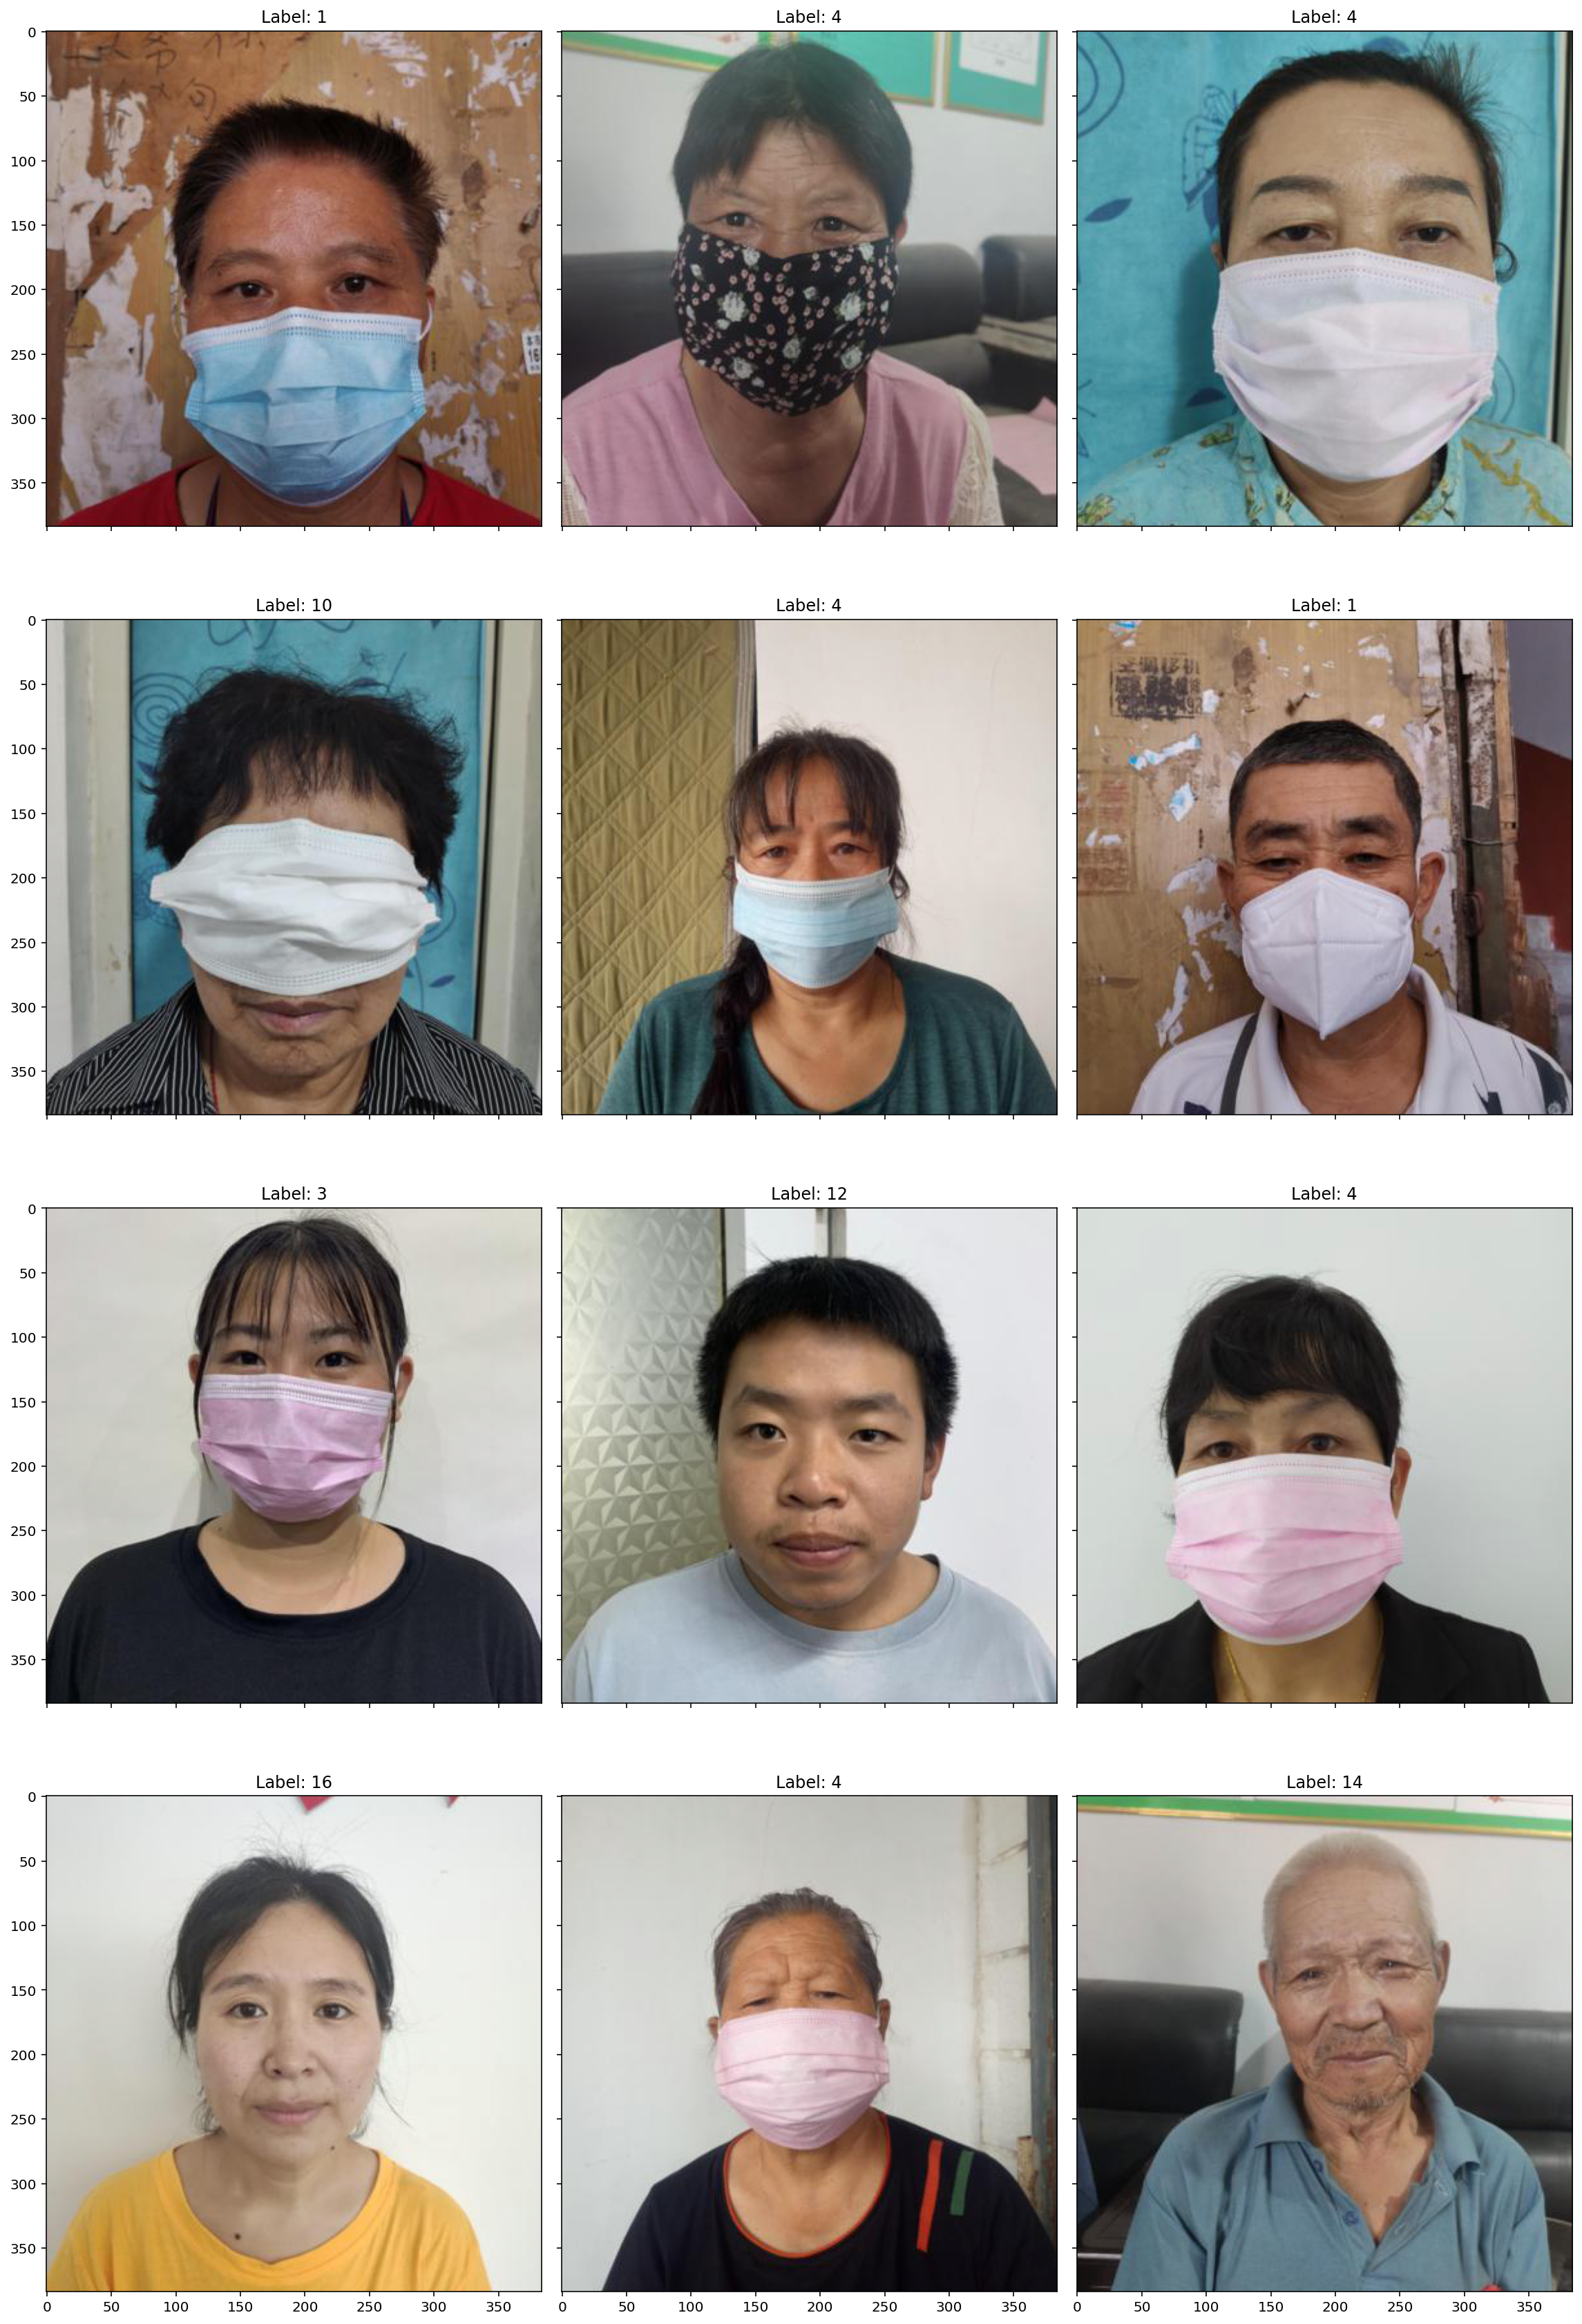

In [36]:
from torchvision import transforms

# augmentation으로 이미지를 normalize 했기 때문에, 역으로 다시 normalize 해줘야한다
inv_normalize = transforms.Normalize(
    mean = [-m / s for m, s in zip(mean, std)],
    std = [1 / s for s in std]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols + 1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols + 1)].set_title(f'Label: {labels[i]}')
    
plt.tight_layout()

### Model

In [22]:
# num_classes = 18
# model_name = 'efficientnet-b0'
# model = EfficientNet.from_pretrained(model_name)
# model.classifier = nn.Sequential(
#     nn.Linear(1000, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, num_classes),
# )
# model.cuda()

In [37]:
model_name = 'efficientnet_b0_timm'
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=18)
model.cuda()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResi

In [38]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = AdamP(model.parameters(), lr=lr)

In [39]:
start = time.time()
get_current_time()

logger = SummaryWriter(log_dir=f'{log_dir}/train')

best_val_loss = np.inf
for e in range(epoch):
    for i, data in enumerate(tqdm(whole_loader)):
        # training
        model.train()
        imgs, labels = data
        imgs = imgs.float().cuda()
        labels = labels.long().cuda()
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        pred_label = torch.argmax(outputs, 1)
        acc = torch.sum(pred_label == labels).item() / len(imgs)
        train_f1 = f1_score(labels.cpu().detach().numpy(), pred_label.cpu().detach().numpy(), average="macro")
        
        logger.add_scalar("Train/loss", loss, e * len(whole_loader) + i)
        logger.add_scalar("Train/accuracy", acc, e * len(whole_loader) + i)
        logger.add_scalar("Train/F1-score", train_f1, e * len(whole_loader) + i)
        
#         grid = torchvision.utils.make_grid(imgs)
#         logger.add_image('image', grid, 0)
#         logger.add_graph(model, imgs)
        
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'[Train] Epoch: {e + 1} | Loss: {(loss.item()):.5f} | Acc: {(acc):.5f} | F1 Score: {train_f1:.4f}')
    
    for val_i, data in enumerate(tqdm(val_loader)):
        model.eval()
        imgs, labels = data
        imgs = imgs.float().cuda()
        labels = labels.long().cuda()

        with torch.no_grad():
            outputs = model(imgs)

        loss = criterion(outputs, labels)
        pred_label = torch.argmax(outputs, 1)
        acc = torch.sum(pred_label == labels).item() / len(imgs)
        val_f1 = f1_score(labels.cpu().detach().numpy(), pred_label.cpu().detach().numpy(), average="macro")
        if loss < best_val_loss:
            print(
                f"New best model for val loss: {loss:.4}! saving the best model..."
            )
            save_path = os.path.join(log_dir, model_name)
            Path(save_path).mkdir(exist_ok=True)
            torch.save(model.state_dict(), f"{log_dir}/{model_name}/best.pth")
            best_val_f1 = val_f1
        
        logger.add_scalar("Val/loss", loss, e * len(val_loader) + val_i)
        logger.add_scalar("Val/accuracy", acc, e * len(val_loader) + val_i)
        logger.add_scalar("Val/F1-score", val_f1, e * len(val_loader) + val_i)

        if val_i % 100 == 99:
            print(f'[Val] Epoch: {e + 1} | Loss: {(loss.item()):.5f} | Acc: {(acc):.5f} | F1 Score: {val_f1:.4f}')

save_path = os.path.join(log_dir, model_name)
Path(save_path).mkdir(exist_ok=True)
torch.save(model.state_dict(), f"{log_dir}/{model_name}/last.pth")
            
times = time.time() - start
minute, sec = divmod(times, 60)
print(f'Finish Training! Taken time is {minute} minutes {sec} seconds')

  0%|          | 0/1182 [00:00<?, ?it/s]

Current Time is 4/8 17:21:49


  8%|▊         | 100/1182 [00:49<14:55,  1.21it/s]

[Train] Epoch: 1 | Loss: 0.44531 | Acc: 0.84375 | F1 Score: 0.6751


 17%|█▋        | 200/1182 [01:32<06:46,  2.42it/s]

[Train] Epoch: 1 | Loss: 0.33871 | Acc: 0.90625 | F1 Score: 0.8913


 25%|██▌       | 300/1182 [02:19<07:37,  1.93it/s]

[Train] Epoch: 1 | Loss: 0.22369 | Acc: 0.87500 | F1 Score: 0.8371


 34%|███▍      | 400/1182 [03:05<05:52,  2.22it/s]

[Train] Epoch: 1 | Loss: 0.39997 | Acc: 0.84375 | F1 Score: 0.6206


 42%|████▏     | 500/1182 [03:59<07:49,  1.45it/s]

[Train] Epoch: 1 | Loss: 0.29078 | Acc: 0.84375 | F1 Score: 0.7172


 51%|█████     | 600/1182 [04:47<05:57,  1.63it/s]

[Train] Epoch: 1 | Loss: 0.16541 | Acc: 0.93750 | F1 Score: 0.7830


 59%|█████▉    | 700/1182 [05:40<03:50,  2.09it/s]

[Train] Epoch: 1 | Loss: 0.18233 | Acc: 0.87500 | F1 Score: 0.5852


 68%|██████▊   | 800/1182 [06:29<02:27,  2.58it/s]

[Train] Epoch: 1 | Loss: 0.35911 | Acc: 0.87500 | F1 Score: 0.6673


 76%|███████▌  | 900/1182 [07:14<02:04,  2.27it/s]

[Train] Epoch: 1 | Loss: 0.05778 | Acc: 1.00000 | F1 Score: 1.0000


 85%|████████▍ | 1000/1182 [08:05<01:13,  2.49it/s]

[Train] Epoch: 1 | Loss: 0.20989 | Acc: 0.90625 | F1 Score: 0.6803


 93%|█████████▎| 1100/1182 [08:54<01:02,  1.32it/s]

[Train] Epoch: 1 | Loss: 0.23249 | Acc: 0.93750 | F1 Score: 0.8764


100%|██████████| 1182/1182 [09:33<00:00,  2.06it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/opt/ml/code/results/efficientnet_b0_timm/last.pth'

### Test

In [40]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform
    
    def set_transform(self, transform):
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        image_transform = self.transform(image=np.array(image))['image']
        return image_transform

    def __len__(self):
        return len(self.img_paths)

In [28]:
# If you have pretrained, use this code
# save_path = os.path.join(log_dir, model_name)
# model_path = os.path.join(save_path, "last.pth")
# model.load_state_dict(torch.load(model_path, map_location="cuda"))

<All keys matched successfully>

In [43]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = Compose([
    CenterCrop(384, 384, p=1.0),
    Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0),
], p=1.0)

test_dataset = TestDataset(image_paths)
test_dataset.set_transform(transform)

test_loader = DataLoader(
    test_dataset,
    batch_size = 64,
    shuffle=False,
    drop_last=False,
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(test_loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

submission_dir = '/opt/ml/code'

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(submission_dir, 'submission.csv'), index=False)
print('test inference is done!')

100%|██████████| 197/197 [02:44<00:00,  1.20it/s]

test inference is done!
